In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

rolling_period = 20

def read_system_json(algo, env, env_n, seed):
    seed = f"seed_{seed}"
    path = f"../results/{algo}/{env}/envs_{env_n}/{seed}/"
    with open(path + "metrics.json", "r") as f:
        data = json.load(f)

    data = data[env][algo][seed]
    records = {}
    for key in data.keys():
        n = key.split("_")[1]
        if len(n) > 3: continue # skip abs metric
        entry = {"mean_episode_returns": data[key]["mean_episode_returns"][0]}
        records[int(n)] = entry
    df = pd.DataFrame.from_dict(records, orient="index")
    df[f"rolling_{rolling_period}"] = df["mean_episode_returns"].rolling(rolling_period, min_periods=1).mean()
    
    return df

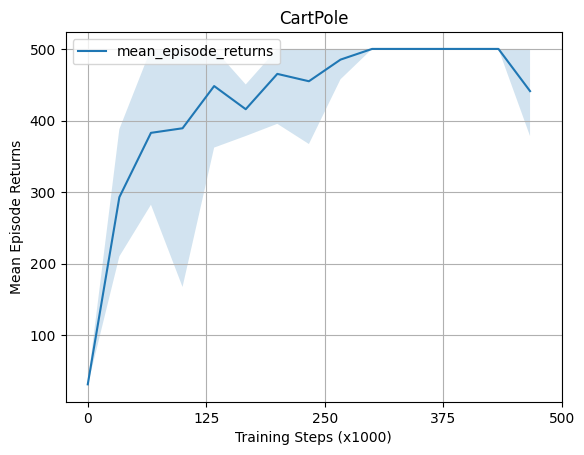

In [12]:
# requires tests with CartPole with seeds of 42, 43, 44
seed_list = [42, 43, 44]

dfs = []
for seed in seed_list:
    df = read_system_json("PPO", "CartPole-v1", 4, seed)
    dfs.append(df)

df_concat = pd.concat(dfs)
by_row_index = df_concat.groupby(df_concat.index)
df_mean = by_row_index.mean()
ax = df_mean.plot(y="mean_episode_returns", title="CartPole")

small = by_row_index.min().mean_episode_returns
large = by_row_index.max().mean_episode_returns
plt.fill_between(df_mean.index, small, large, alpha=0.2)

plt.ylabel("Mean Episode Returns")
plt.xlabel("Training Steps (x1000)")
plt.xticks(np.linspace(0, 15, 5), np.linspace(0, 5e2, 5).astype(int))
plt.grid(True)
plt.savefig("../Images/cartpole_mean.png")


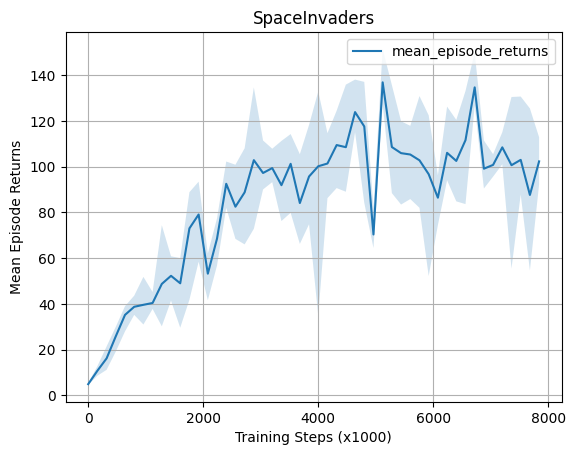

In [17]:
# requires tests with SpaceInvaders with seeds of 42, 43, 44
seed_list = [42, 43, 44]

dfs = []
for seed in seed_list:
    df = read_system_json("ppo", "SpaceInvaders-MinAtar", 16, seed)
    dfs.append(df)

df_concat = pd.concat(dfs)
by_row_index = df_concat.groupby(df_concat.index)
df_mean = by_row_index.mean()
ax = df_mean.plot(y="mean_episode_returns", title="SpaceInvaders")

small = by_row_index.min().mean_episode_returns
large = by_row_index.max().mean_episode_returns
plt.fill_between(df_mean.index, small, large, alpha=0.2)

plt.ylabel("Mean Episode Returns")
plt.xlabel("Training Steps (x1000)")
plt.xticks(np.linspace(0, 50, 5), np.linspace(0, 8e3, 5).astype(int))
plt.grid(True)
plt.savefig("../Images/SpaceInvaders_mean.png")

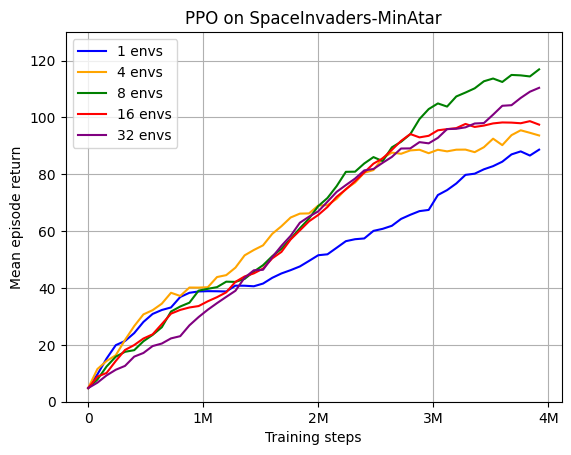

In [12]:
env = "SpaceInvaders-MinAtar"

env_ns = [1, 4, 8, 16, 32]
seeds = [42]
colors = ['blue', "orange", 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

ax = plt.gca()

i = 0
last_vals = []
for env_n in env_ns:
    for seed in seeds:
        df = read_system_json("ppo", env, env_n, seed)
        # df.plot(y="mean_episode_returns", label=None, alpha=0.2, ax=ax, color=colors[i])
        df.plot(y="rolling_20", label=f"{env_n} envs", ax=ax, color=colors[i])
        last_vals.append(df["rolling_20"].iloc[-1])

        i += 1

plt.title(f"PPO on {env}")
plt.xlabel("Training steps")
plt.ylabel("Mean episode return")
plt.xticks([0, 12.5, 25, 37.5, 50], ["0", "1M", "2M", "3M", "4M"])
plt.ylim(0, 130)

ax.grid(True)

plt.savefig(f"../Images/ppo_{env}.png")
